## Media Bias Detection (Using Sigmoid-Based Hyperparameter-Tuned Neutrosophic Loss)

##### 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

2025-11-02 14:01:31.378323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762092091.400598      91 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762092091.407634      91 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##### 2. Load Dataset

In [2]:
file = r"/kaggle/input/bias-detection-dataset-processed/balanced_bias_data_parquet.parquet"
balanced_df = pd.read_parquet(file)

print(balanced_df)
print("\nColumns:")
print(balanced_df.columns)

         Unnamed: 0                                               text  \
0                 0  im okay with it being there and im not religious.   
1                 1  nn chchchchina nnlets dialogue about this wond...   
2                 2  ianbetteridge firefox2, no idea what version o...   
3                 3  so kool!i didnt know he came to alaska.i was 1...   
4                 4  catwoman123 if you know the real demi moore an...   
...             ...                                                ...   
2856798     2856798  i see that someone answered on your talk page....   
2856799     2856799  sheriff joe as you affectionately call him had...   
2856800     2856800  your incredulity doesnt make your claim any mo...   
2856801     2856801  find someone elses comment to spew your islamo...   
2856802     2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                             

In [3]:
print(balanced_df.shape)

(2856803, 8)


##### 3. Tokenisation & Padding

In [ ]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['text'])

X = tokenizer.texts_to_sequences(balanced_df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 4. Train-Test Split

In [ ]:
y = balanced_df[['bias', 'sentiment', 'toxic']]
print(y)
print(y.shape)

         bias  sentiment  toxic
0           1          2      0
1           1          2      0
2           1          2      0
3           1          2      0
4           1          2      0
...       ...        ...    ...
2856798     0          1      0
2856799     0          1      0
2856800     0          1      0
2856801     0          1      0
2856802     0          1      0

[2856803 rows x 3 columns]
(2856803, 3)


In [7]:
# split for training, testing and validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [ ]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

# convert to numpy.
y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (1999762, 100)
X_test: (428520, 100)
X_valid: (428521, 100)
y_train_bias: (1999762,)
y_train_sentiment: (1999762,)
y_train_toxic: (1999762,)
y_test_bias: (428520,)
y_test_sentiment: (428520,)
y_test_toxic: (428520,)
y_valid_bias: (428521,)
y_valid_sentiment: (428521,)
y_valid_toxic: (428521,)


In [ ]:
# convert to categorical.
y_train_bias_oh = to_categorical(y_train_bias, num_classes=3)
y_valid_bias_oh = to_categorical(y_valid_bias, num_classes=3)
y_test_bias_oh = to_categorical(y_test_bias, num_classes=3)

y_train_sentiment_oh = to_categorical(y_train_sentiment, num_classes=3)
y_valid_sentiment_oh = to_categorical(y_valid_sentiment, num_classes=3)
y_test_sentiment_oh = to_categorical(y_test_sentiment, num_classes=3)

y_train_toxic_oh = to_categorical(y_train_toxic, num_classes=2)
y_valid_toxic_oh = to_categorical(y_valid_toxic, num_classes=2)
y_test_toxic_oh = to_categorical(y_test_toxic, num_classes=2)

##### 5. Neutrosophic Sigmoid Loss Function Definition

In [10]:
def neutrosophic_sigmoid_loss(num_classes, alpha=1.0, beta=0.5, gamma=0.5):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # Safe sigmoid with clipping
        y_sigmoid = tf.clip_by_value(tf.nn.sigmoid(y_pred), 1e-7, 1-1e-7)

        truth = -y_true * tf.math.log(y_sigmoid)
        falsity = -(1 - y_true) * tf.math.log(1 - y_sigmoid)
        indeterminacy = 1.0 - tf.abs(y_sigmoid - 0.5) * 2.0

        neutro_loss = alpha * truth + beta * falsity + gamma * indeterminacy
        return tf.reduce_mean(neutro_loss)
    return loss_fn

##### 6. Model Architecture

In [11]:
def build_model(alpha=0.5, beta=0.3, gamma=0.2):
    input_layer = Input(shape=(X_train.shape[1],))
    
    x = Embedding(input_dim=MAX_VOCAB, output_dim=128)(input_layer)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    bias_length = 3
    sentiment_length = 3
    toxic_length = 2

    output_b = Dense(bias_length, activation='linear', name='output_b')(x)
    output_s = Dense(sentiment_length, activation='linear', name='output_s')(x)
    output_t = Dense(toxic_length, activation='linear', name='output_t')(x)

    model = Model(inputs=input_layer, outputs=[output_b, output_s, output_t])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss={
            "output_b": neutrosophic_sigmoid_loss(alpha, beta, gamma),
            "output_s": neutrosophic_sigmoid_loss(alpha, beta, gamma),
            "output_t": neutrosophic_sigmoid_loss(alpha, beta, gamma),
        },
        metrics={
            "output_b": "categorical_accuracy",
            "output_s": "categorical_accuracy",
            "output_t": "categorical_accuracy"
        }
    )
    return model

##### 7. α, β, γ combinations

In [ ]:
combinations = [
    (0.6, 0.3, 0.1),
    (0.5, 0.4, 0.1),
    (0.5, 0.3, 0.2),
    (0.4, 0.4, 0.2),
    (0.8, 0.15, 0.05),
    (0.7, 0.2, 0.1),
    (0.5, 0.45, 0.05),
    (0.4, 0.5, 0.1),
    (0.45, 0.35, 0.2),
    (0.4, 0.3, 0.3),
    (0.8, 0.1, 0.1),
    (0.2, 0.3, 0.5)
]

##### 8. Model Training

In [13]:
results = []
flag = 0
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
models_created = []
history_created = []

for alpha, beta, gamma in combinations:
    print(f"\nTraining with α={alpha}, β={beta}, γ={gamma}")
    model = build_model(alpha, beta, gamma)
    history = model.fit(
        X_train,
        {
            "output_b": y_train_bias_oh,
            "output_s": y_train_sentiment_oh,
            "output_t": y_train_toxic_oh
        },
        validation_data=(
            X_valid,
            {
                "output_b": y_valid_bias_oh,
                "output_s": y_valid_sentiment_oh,
                "output_t": y_valid_toxic_oh
            }
        ),
        epochs=10,
        batch_size=8192,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    acc_b = history.history['val_output_b_categorical_accuracy'][-1]
    acc_s = history.history['val_output_s_categorical_accuracy'][-1]
    acc_t = history.history['val_output_t_categorical_accuracy'][-1]
    
    results.append({
        "alpha": alpha,
        "beta": beta,
        "gamma": gamma,
        "bias_val_acc": acc_b,
        "sentiment_val_acc": acc_s,
        "toxic_val_acc": acc_t
    })
    models_created.append(model)
    history_created.append(history)


Training with α=0.6, β=0.3, γ=0.1


I0000 00:00:1762092390.620308      91 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1762092401.392120     156 cuda_dnn.cc:529] Loaded cuDNN version 90300


245/245 ━━━━━━━━━━━━━━━━━━━━ 142s 538ms/step - loss: 0.8522 - output_b_categorical_accuracy: 0.4894 - output_b_loss: 0.2747 - output_s_categorical_accuracy: 0.4248 - output_s_loss: 0.3022 - output_t_categorical_accuracy: 0.5365 - output_t_loss: 0.2590 - val_loss: 0.6664 - val_output_b_categorical_accuracy: 0.5572 - val_output_b_loss: 0.1930 - val_output_s_categorical_accuracy: 0.4871 - val_output_s_loss: 0.2458 - val_output_t_categorical_accuracy: 0.6066 - val_output_t_loss: 0.2138
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 534ms/step - loss: 0.6376 - output_b_categorical_accuracy: 0.6806 - output_b_loss: 0.1679 - output_s_categorical_accuracy: 0.4827 - output_s_loss: 0.2419 - output_t_categorical_accuracy: 0.5889 - output_t_loss: 0.2149 - val_loss: 0.7244 - val_output_b_categorical_accuracy: 0.6573 - val_output_b_loss: 0.1851 - val_output_s_categorical_accuracy: 0.4357 - val_output_s_loss: 0.2869 - val_output_t_categorical_accuracy: 0.6001 - val_output_t_loss: 0.2412
Epoch 3/10
245/

In [ ]:
models_created[0].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,694,937 (17.91 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 3,129,617 (11.94 MB)

In [16]:
results_df = pd.DataFrame(results)
print("\nValidation accuracy summary:")
print(results_df)


Validation accuracy summary:
    alpha  beta  gamma  bias_val_acc  sentiment_val_acc  toxic_val_acc
0    0.60  0.30   0.10      0.833166           0.710362       0.813535
1    0.50  0.40   0.10      0.844481           0.893510       0.837733
2    0.50  0.30   0.20      0.859057           0.900474       0.844281
3    0.40  0.40   0.20      0.853575           0.903673       0.853739
4    0.80  0.15   0.05      0.799233           0.813855       0.835280
5    0.70  0.20   0.10      0.832965           0.714499       0.828933
6    0.50  0.45   0.05      0.797485           0.843445       0.839817
7    0.40  0.50   0.10      0.845779           0.890897       0.843063
8    0.45  0.35   0.20      0.856436           0.898306       0.849720
9    0.40  0.30   0.30      0.860721           0.904565       0.851783
10   0.80  0.10   0.10      0.401376           0.897923       0.600006
11   0.20  0.30   0.50      0.857053           0.906831       0.857949


##### 9. Model Evaluation

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.6, β=0.3, γ=0.1
====================== Bias Task ======================
Accuracy: 0.832861943433212
                 precision    recall  f1-score   support

  Highly Biased       0.85      0.85      0.85    122856
        Neutral       0.85      0.89      0.87    133667
Slightly Biased       0.81      0.78      0.79    171997

       accuracy                           0.83    428520
      macro avg       0.84      0.84      0.84    428520
   weighted avg       0.83      0.83      0.83    428520


==================== Sentiment Task ====================
Accuracy: 0.7098268458881732
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     94353
     Neutral       0.60      0.87      0.71    147428
    Positive       0.81      0.94      0.87    186739

    accuracy                           0.71    428520
   macro avg       0.47      0.60      0.53    428520
weighted avg       0.5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Not Toxic       0.90      0.77      0.83    257111
       Toxic       0.72      0.88      0.79    171409

    accuracy                           0.81    428520
   macro avg       0.81      0.82      0.81    428520
weighted avg       0.83      0.81      0.82    428520





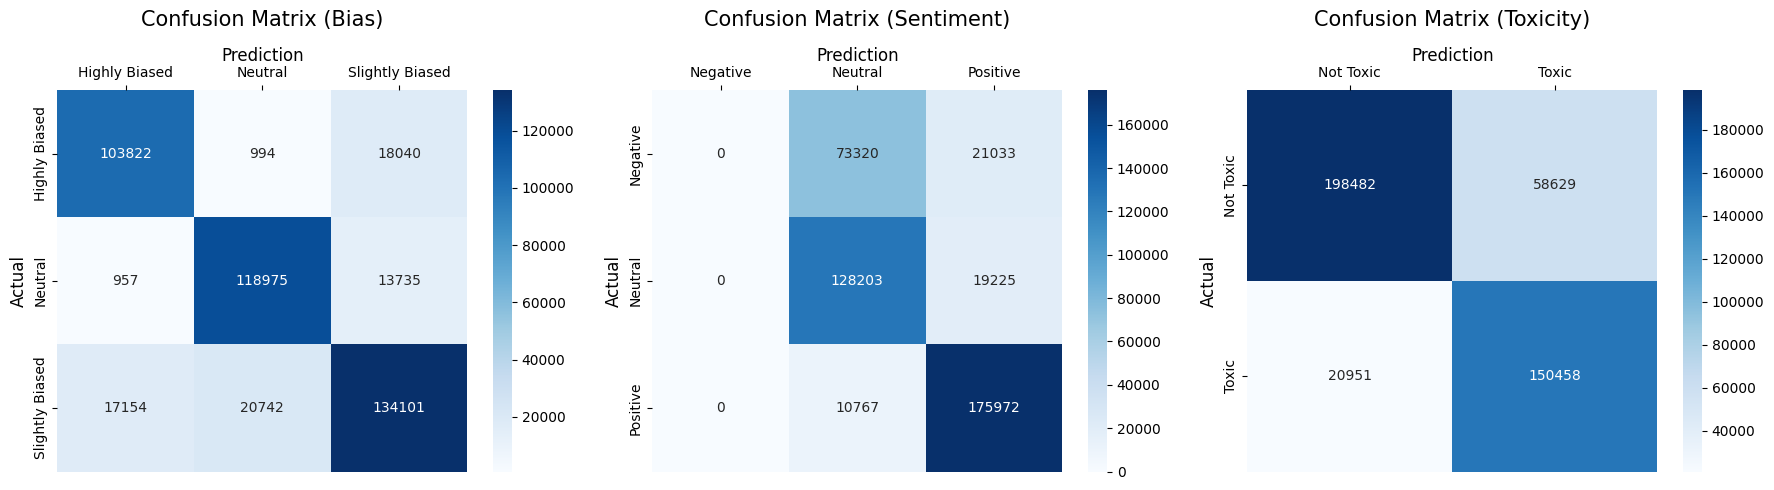

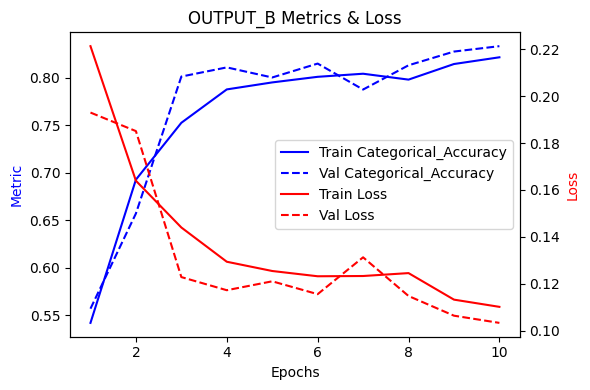

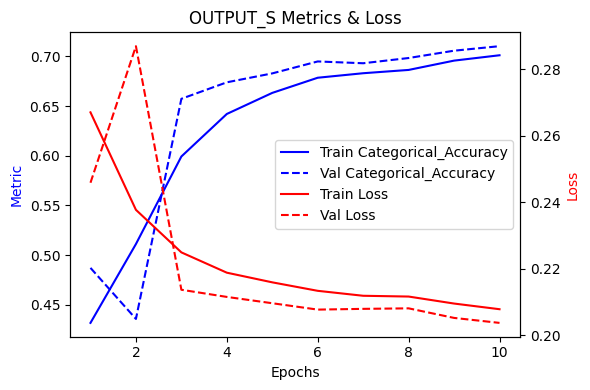

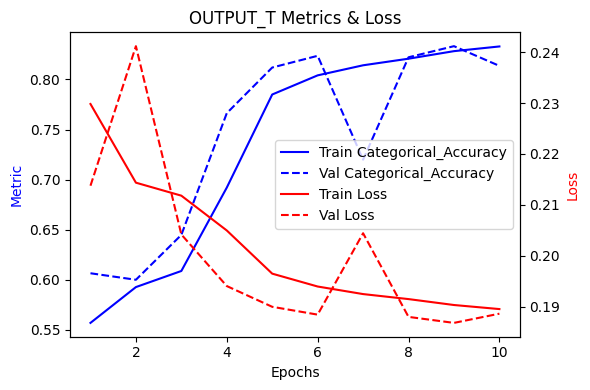


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.5, β=0.4, γ=0.1
====================== Bias Task ======================
Accuracy: 0.8438275926444506
                 precision    recall  f1-score   support

  Highly Biased       0.86      0.86      0.86    122856
        Neutral       0.85      0.90      0.87    133667
Slightly Biased       0.82      0.79      0.81    171997

       accuracy                           0.84    428520
      macro avg       0.85      0.85      0.85    428520
   weighted avg       0.84      0.84      0.84    428520


==================== Sentiment Task ====================
Accuracy: 0.8934355455988052
              precision    recall  f1-score   support

    Negative       0.82      0.89      0.85     94353
     Neutral       0.95      0.85      0.90    147428
    Positive       0.89      0.93      0.91    186739

    accuracy                           0.89    42852

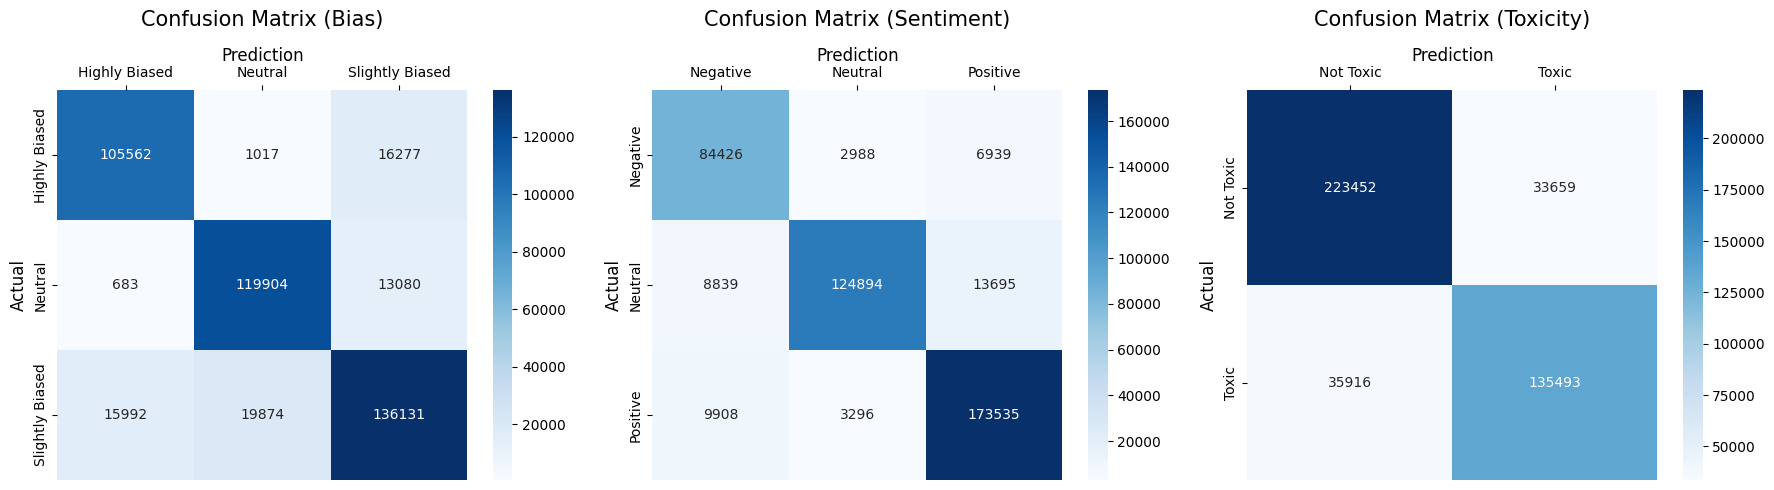

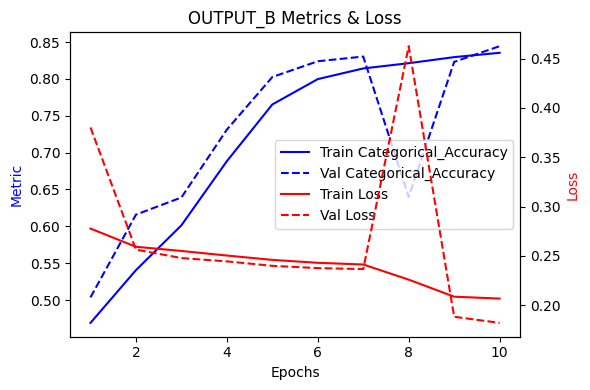

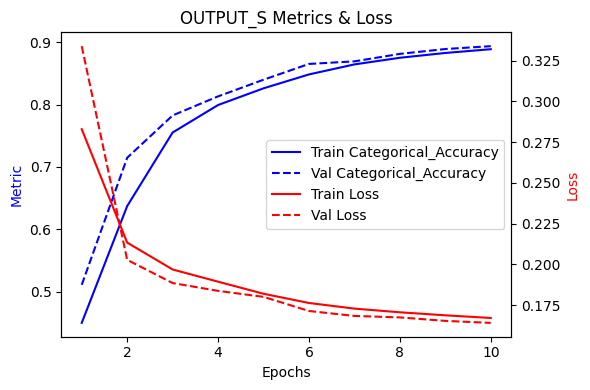

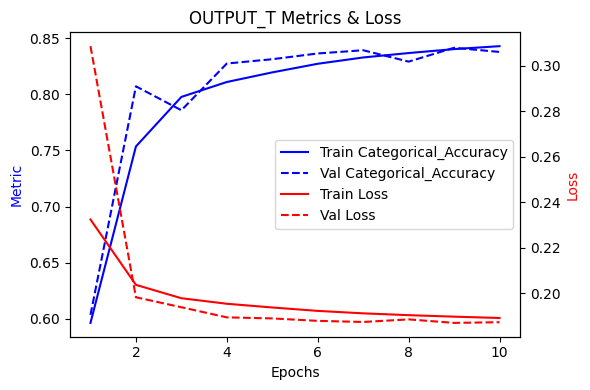


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.5, β=0.3, γ=0.2
====================== Bias Task ======================
Accuracy: 0.8581886493045832
                 precision    recall  f1-score   support

  Highly Biased       0.86      0.91      0.88    122856
        Neutral       0.87      0.89      0.88    133667
Slightly Biased       0.85      0.80      0.82    171997

       accuracy                           0.86    428520
      macro avg       0.86      0.87      0.86    428520
   weighted avg       0.86      0.86      0.86    428520


==================== Sentiment Task ====================
Accuracy: 0.9034164099691963
              precision    recall  f1-score   support

    Negative       0.85      0.88      0.87     94353
     Neutral       0.96      0.85      0.90    147428
    Positive       0.89      0.96      0.92    186739

    accuracy                           0.90    42852

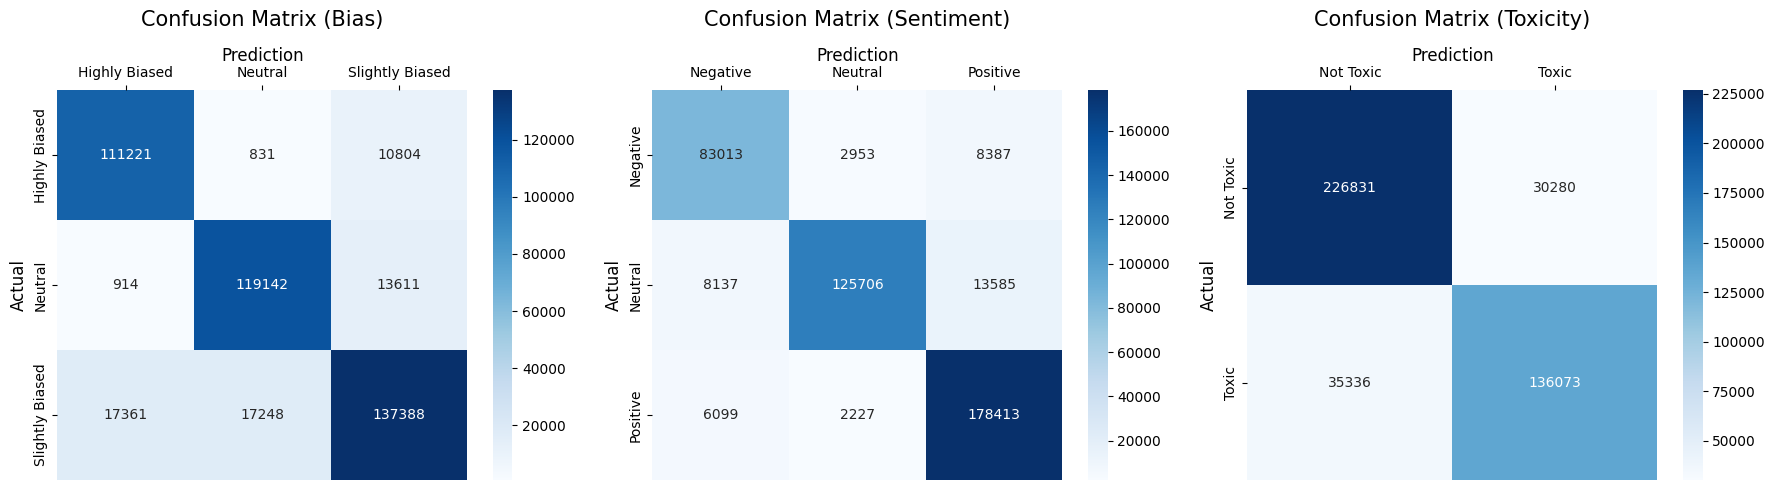

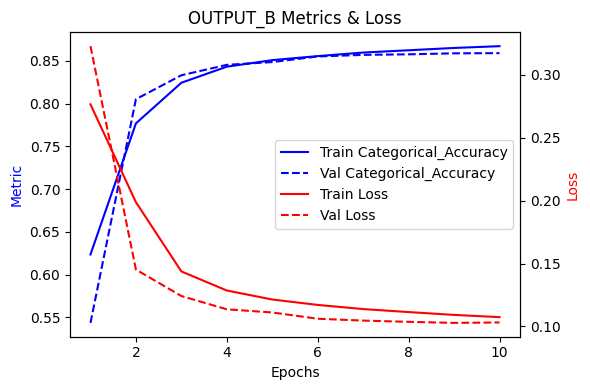

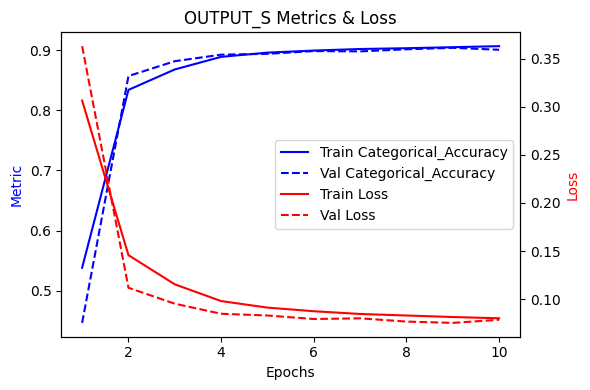

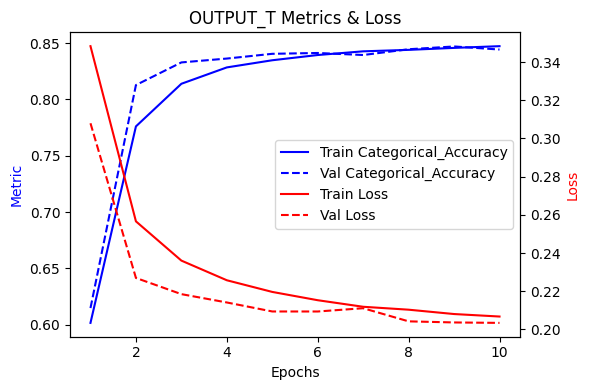


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.4, β=0.4, γ=0.2
====================== Bias Task ======================
Accuracy: 0.8541048259124429
                 precision    recall  f1-score   support

  Highly Biased       0.86      0.89      0.87    122856
        Neutral       0.85      0.91      0.88    133667
Slightly Biased       0.85      0.79      0.82    171997

       accuracy                           0.85    428520
      macro avg       0.85      0.86      0.86    428520
   weighted avg       0.85      0.85      0.85    428520


==================== Sentiment Task ====================
Accuracy: 0.9036847755063941
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     94353
     Neutral       0.96      0.85      0.90    147428
    Positive       0.89      0.96      0.92    186739

    accuracy                           0.90    42852

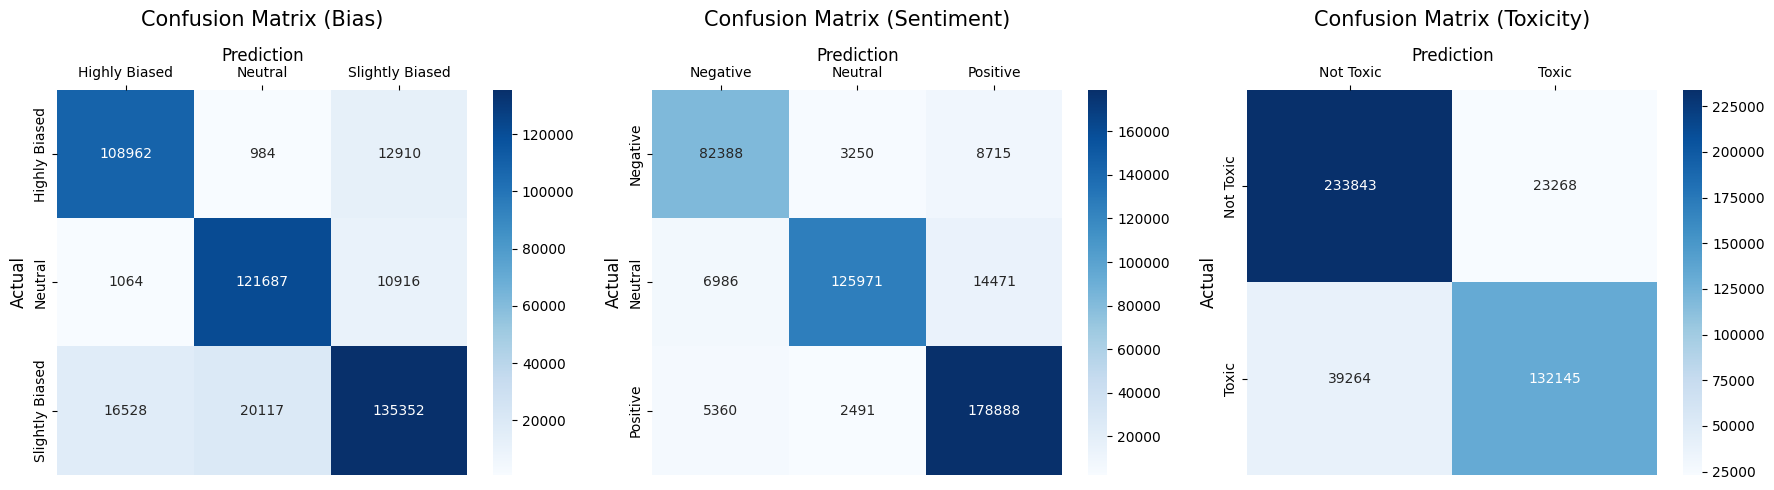

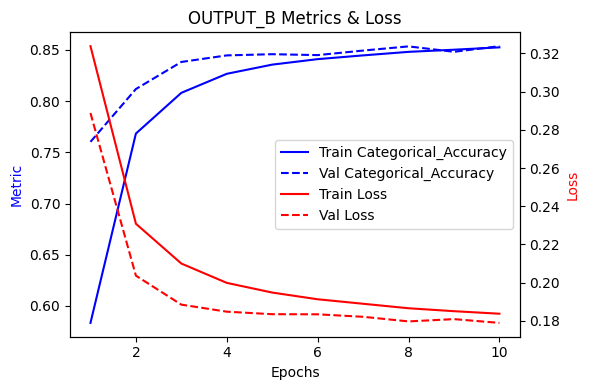

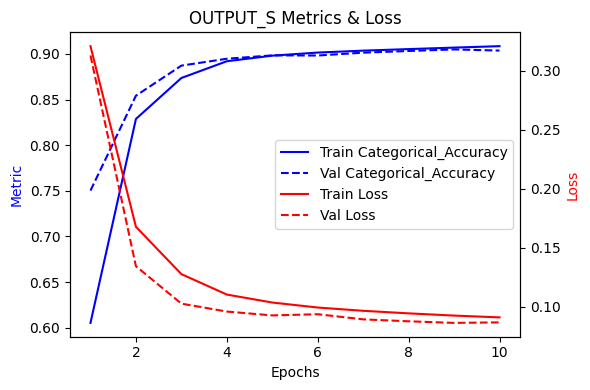

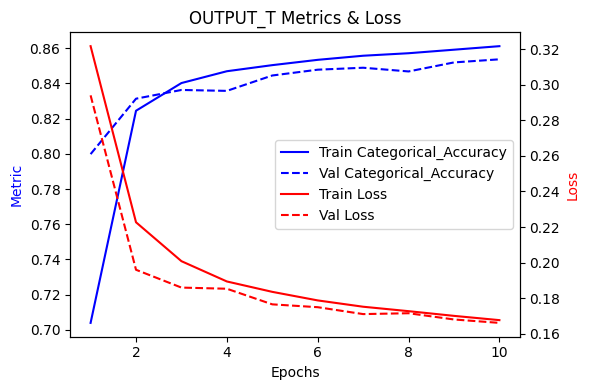


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.8, β=0.15, γ=0.05
====================== Bias Task ======================
Accuracy: 0.7986161672734061
                 precision    recall  f1-score   support

  Highly Biased       0.87      0.76      0.81    122856
        Neutral       0.79      0.90      0.84    133667
Slightly Biased       0.76      0.75      0.75    171997

       accuracy                           0.80    428520
      macro avg       0.81      0.80      0.80    428520
   weighted avg       0.80      0.80      0.80    428520


==================== Sentiment Task ====================
Accuracy: 0.8142583776719873
              precision    recall  f1-score   support

    Negative       0.82      0.64      0.72     94353
     Neutral       0.89      0.78      0.83    147428
    Positive       0.77      0.93      0.84    186739

    accuracy                           0.81    428

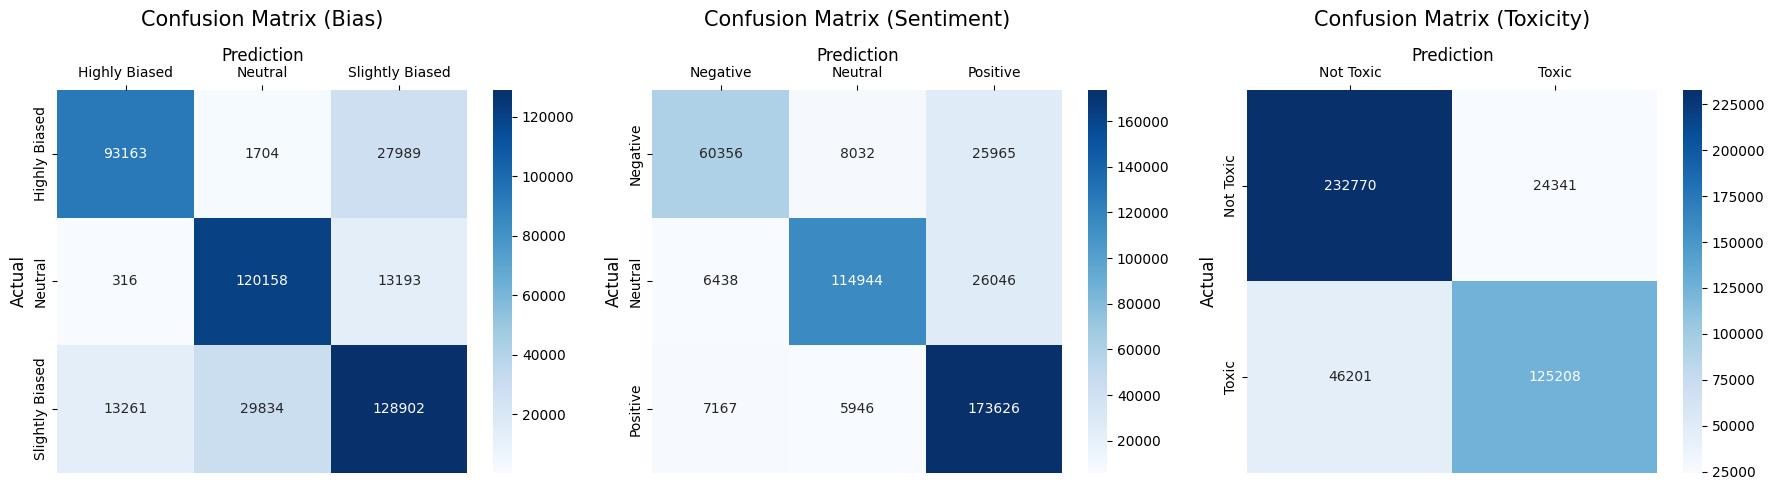

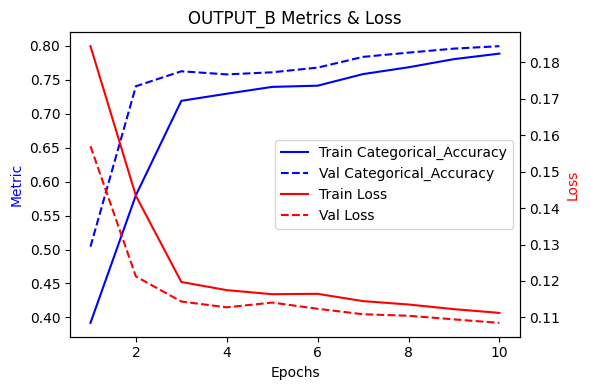

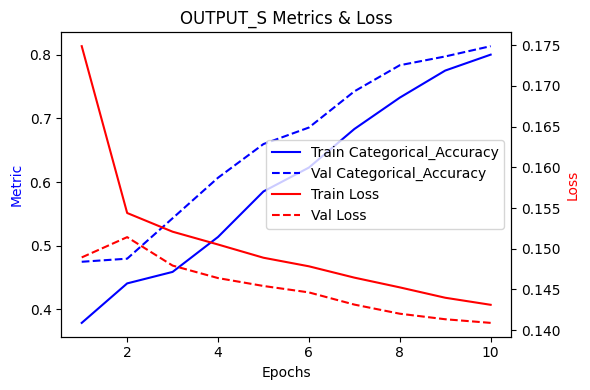

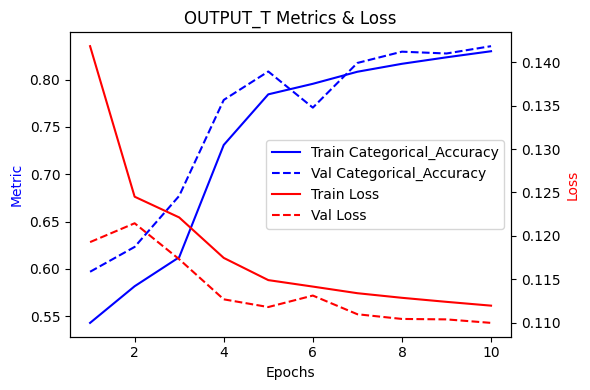


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.7, β=0.2, γ=0.1
====================== Bias Task ======================
Accuracy: 0.8326705871371232
                 precision    recall  f1-score   support

  Highly Biased       0.83      0.86      0.85    122856
        Neutral       0.85      0.90      0.87    133667
Slightly Biased       0.82      0.76      0.79    171997

       accuracy                           0.83    428520
      macro avg       0.83      0.84      0.84    428520
   weighted avg       0.83      0.83      0.83    428520


==================== Sentiment Task ====================
Accuracy: 0.7137473163446281
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     94353
     Neutral       0.58      0.89      0.70    147428
    Positive       0.87      0.93      0.90    186739

    accuracy                           0.71    42852

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Not Toxic       0.88      0.83      0.85    257111
       Toxic       0.76      0.83      0.80    171409

    accuracy                           0.83    428520
   macro avg       0.82      0.83      0.82    428520
weighted avg       0.83      0.83      0.83    428520





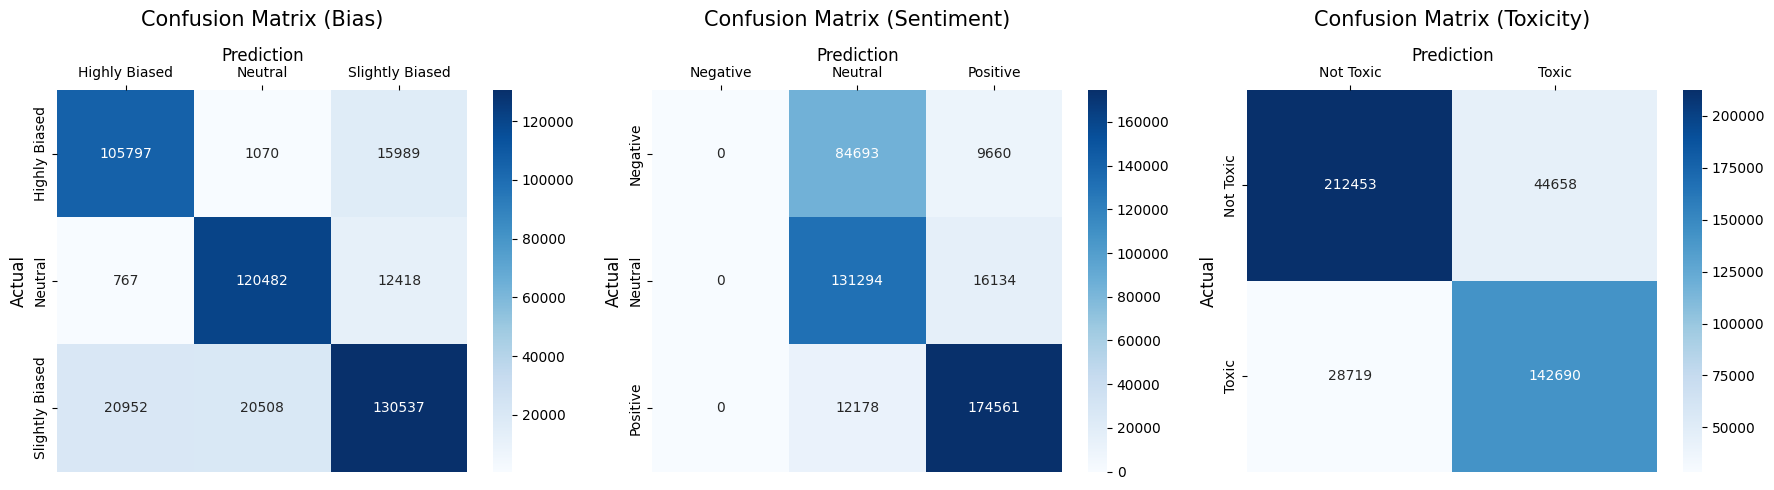

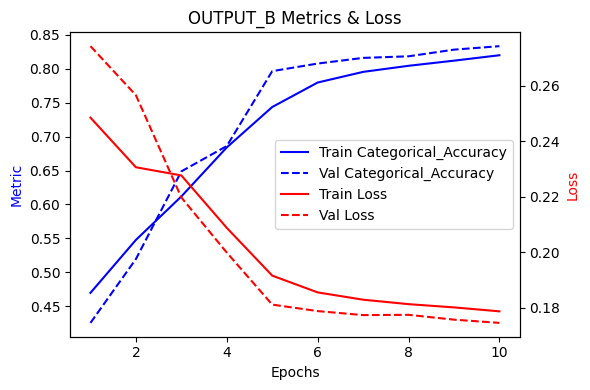

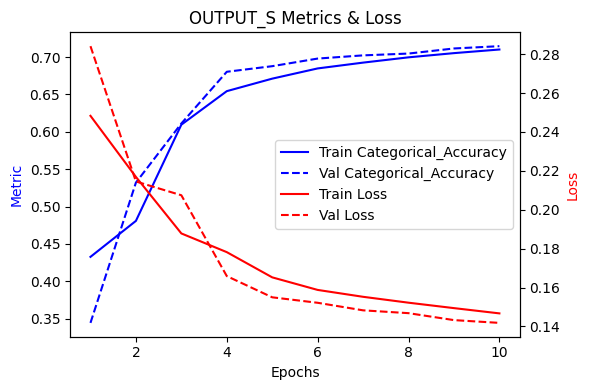

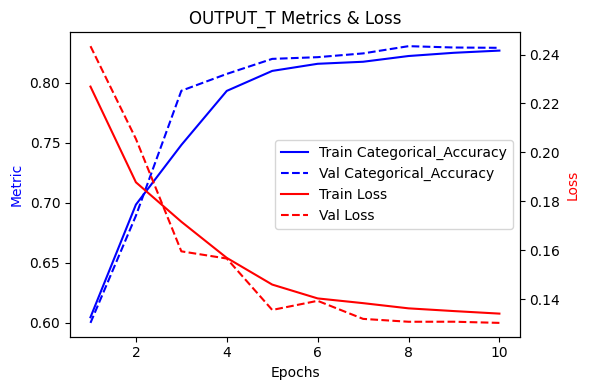


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.5, β=0.45, γ=0.05
====================== Bias Task ======================
Accuracy: 0.7974983664706431
                 precision    recall  f1-score   support

  Highly Biased       0.82      0.83      0.83    122856
        Neutral       0.83      0.83      0.83    133667
Slightly Biased       0.76      0.74      0.75    171997

       accuracy                           0.80    428520
      macro avg       0.80      0.80      0.80    428520
   weighted avg       0.80      0.80      0.80    428520


==================== Sentiment Task ====================
Accuracy: 0.8434985531597124
              precision    recall  f1-score   support

    Negative       0.82      0.71      0.76     94353
     Neutral       0.93      0.81      0.87    147428
    Positive       0.80      0.93      0.86    186739

    accuracy                           0.84    428

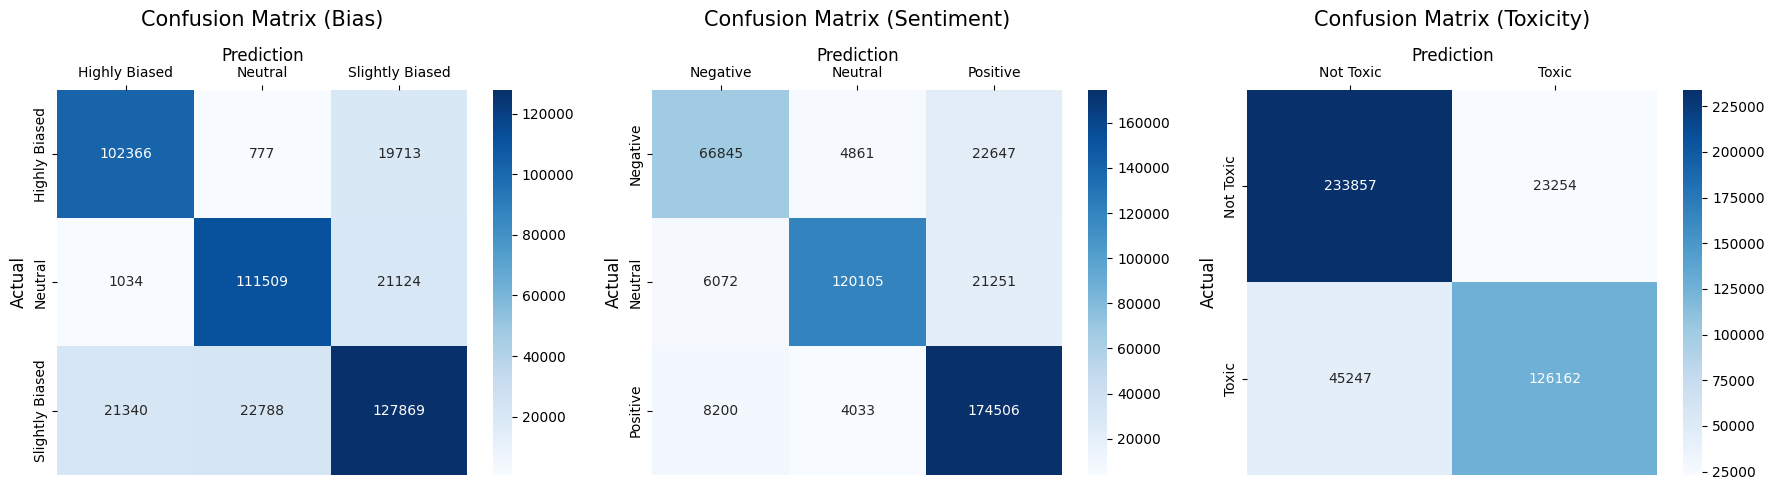

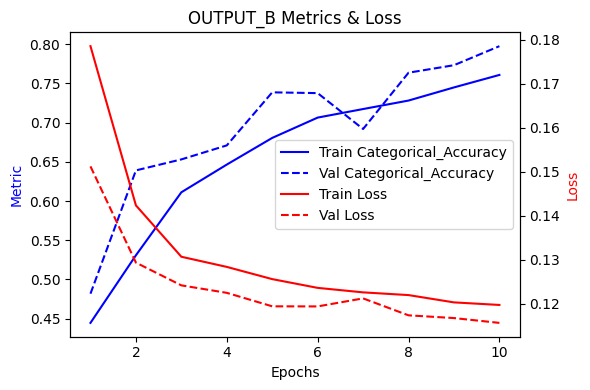

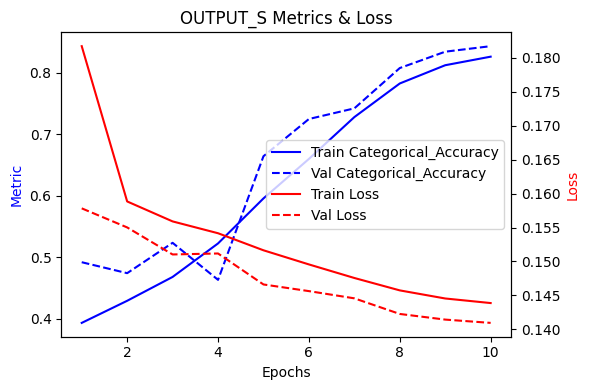

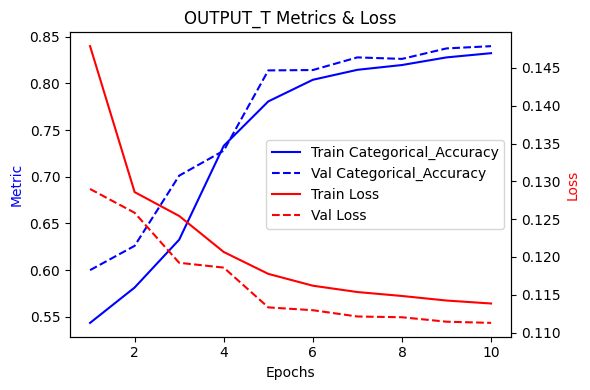


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.4, β=0.5, γ=0.1
====================== Bias Task ======================
Accuracy: 0.8456828152711658
                 precision    recall  f1-score   support

  Highly Biased       0.83      0.90      0.87    122856
        Neutral       0.87      0.88      0.87    133667
Slightly Biased       0.84      0.78      0.81    171997

       accuracy                           0.85    428520
      macro avg       0.85      0.85      0.85    428520
   weighted avg       0.85      0.85      0.84    428520


==================== Sentiment Task ====================
Accuracy: 0.8907798935872304
              precision    recall  f1-score   support

    Negative       0.85      0.86      0.86     94353
     Neutral       0.94      0.85      0.89    147428
    Positive       0.88      0.94      0.91    186739

    accuracy                           0.89    42852

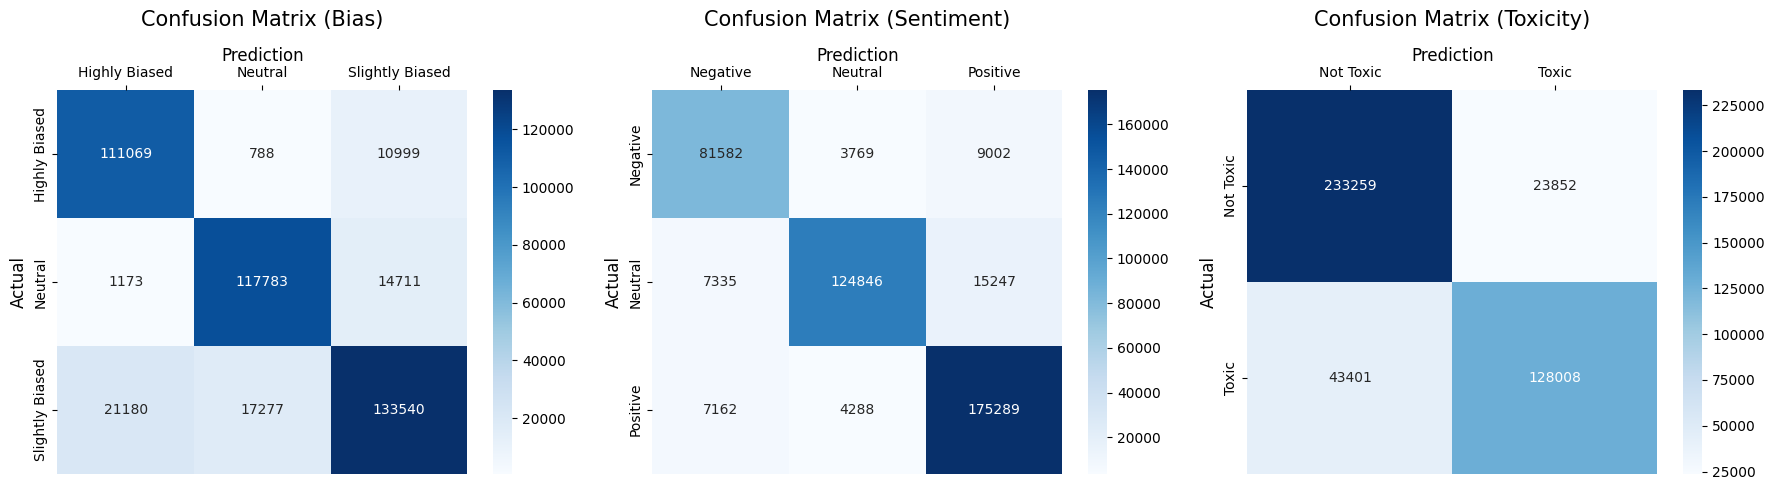

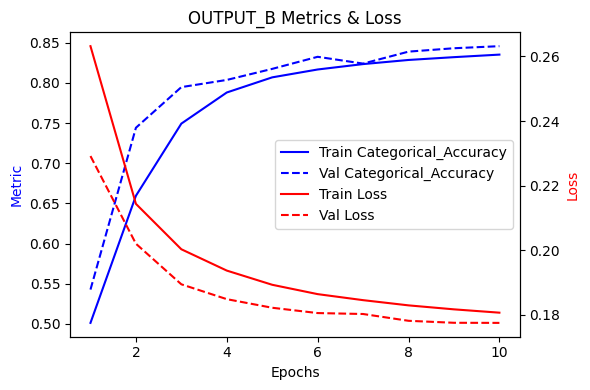

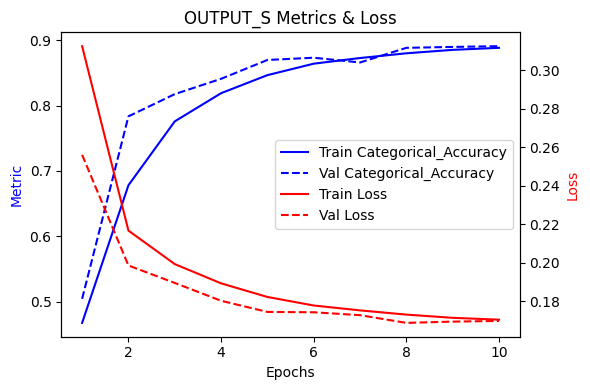

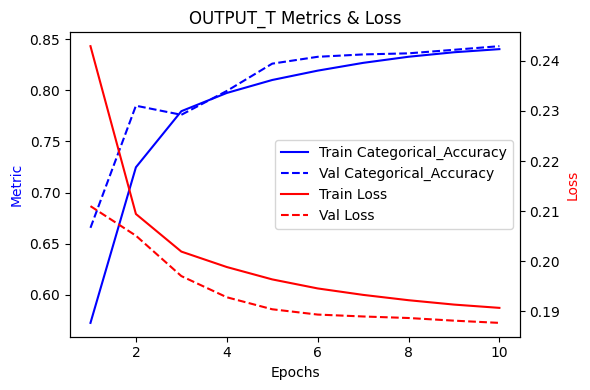


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.45, β=0.35, γ=0.2
====================== Bias Task ======================
Accuracy: 0.8554069821711939
                 precision    recall  f1-score   support

  Highly Biased       0.85      0.91      0.88    122856
        Neutral       0.86      0.90      0.88    133667
Slightly Biased       0.85      0.78      0.82    171997

       accuracy                           0.86    428520
      macro avg       0.86      0.86      0.86    428520
   weighted avg       0.86      0.86      0.85    428520


==================== Sentiment Task ====================
Accuracy: 0.8967726127135256
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85     94353
     Neutral       0.93      0.86      0.89    147428
    Positive       0.91      0.93      0.92    186739

    accuracy                           0.90    428

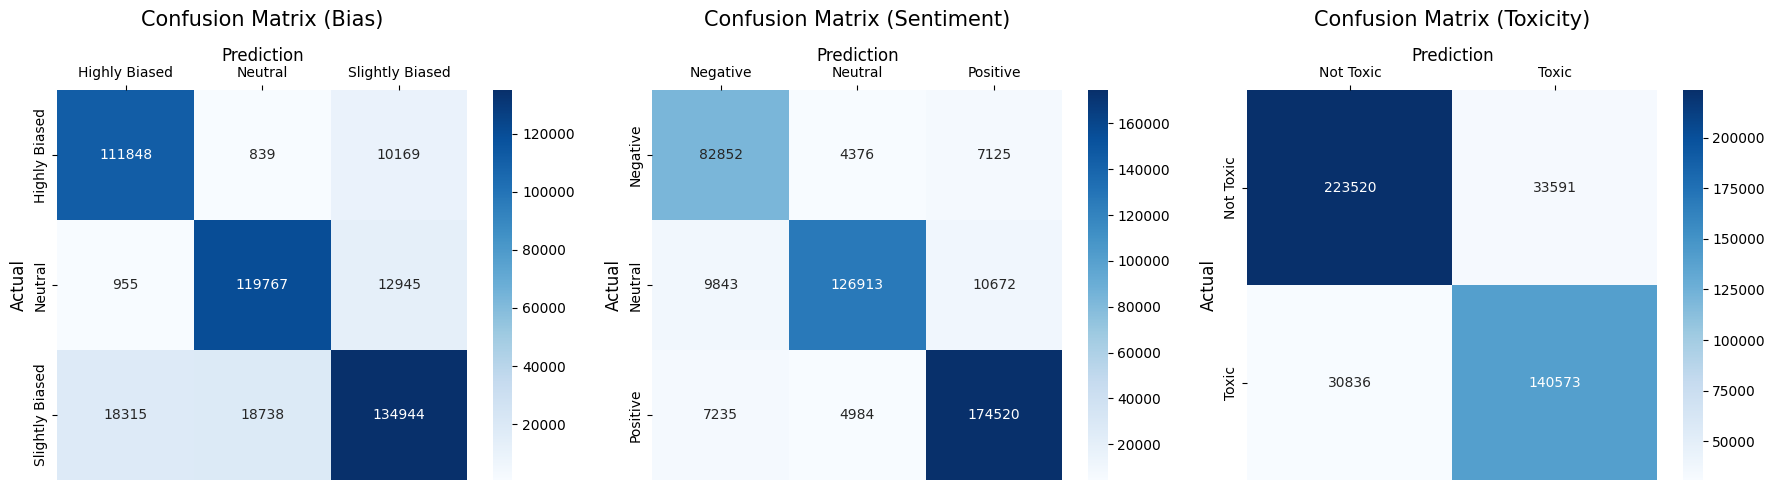

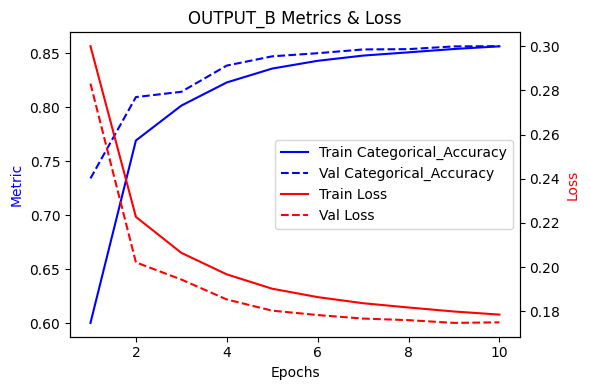

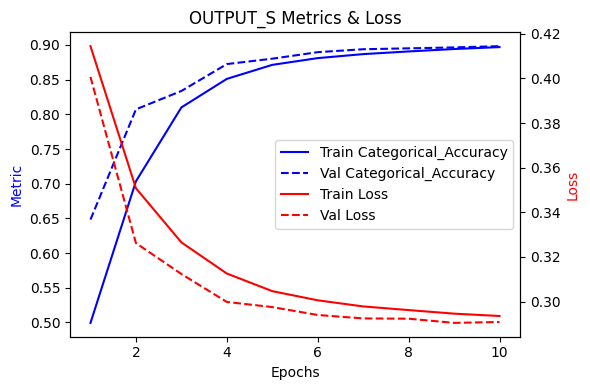

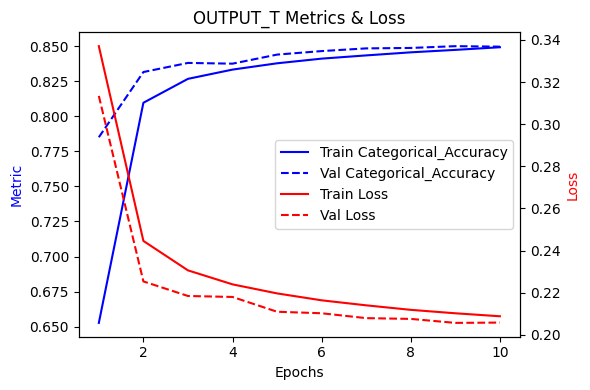


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.4, β=0.3, γ=0.3
====================== Bias Task ======================
Accuracy: 0.8603682441893027
                 precision    recall  f1-score   support

  Highly Biased       0.86      0.91      0.88    122856
        Neutral       0.86      0.90      0.88    133667
Slightly Biased       0.86      0.80      0.83    171997

       accuracy                           0.86    428520
      macro avg       0.86      0.87      0.86    428520
   weighted avg       0.86      0.86      0.86    428520


==================== Sentiment Task ====================
Accuracy: 0.9042588443946606
              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86     94353
     Neutral       0.94      0.87      0.90    147428
    Positive       0.92      0.94      0.93    186739

    accuracy                           0.90    42852

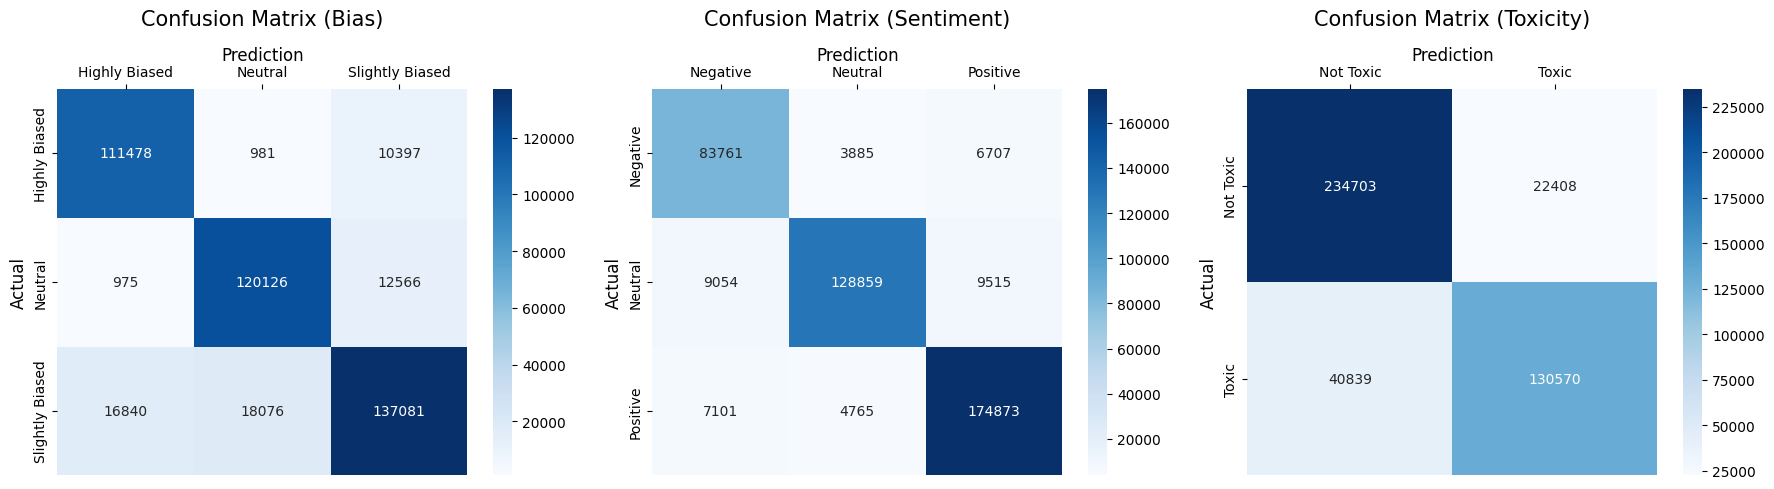

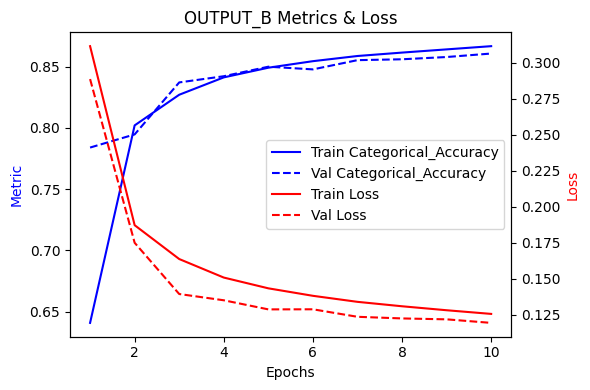

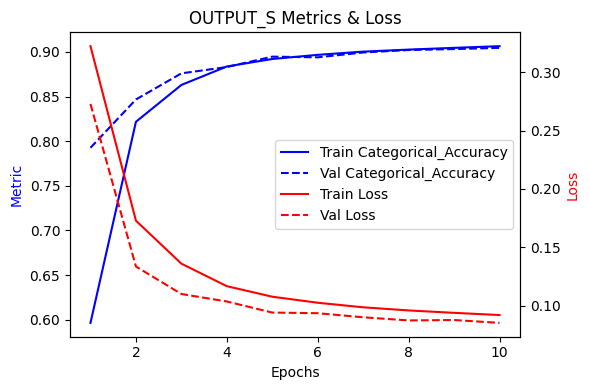

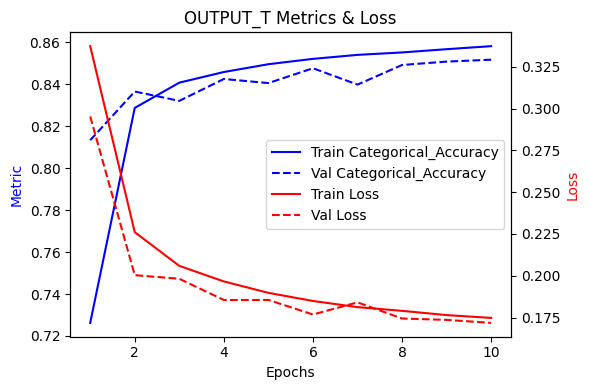


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.8, β=0.1, γ=0.1
====================== Bias Task ======================
Accuracy: 0.4013744982731261


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

  Highly Biased       0.00      0.00      0.00    122856
        Neutral       0.00      0.00      0.00    133667
Slightly Biased       0.40      1.00      0.57    171997

       accuracy                           0.40    428520
      macro avg       0.13      0.33      0.19    428520
   weighted avg       0.16      0.40      0.23    428520


==================== Sentiment Task ====================
Accuracy: 0.8977690656212078
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85     94353
     Neutral       0.94      0.87      0.90    147428
    Positive       0.90      0.93      0.92    186739

    accuracy                           0.90    428520
   macro avg       0.89      0.89      0.89    428520
weighted avg       0.90      0.90      0.90    428520


====================== Toxic Task ======================
Accuracy: 0.5999976663866331


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Not Toxic       0.60      1.00      0.75    257111
       Toxic       0.00      0.00      0.00    171409

    accuracy                           0.60    428520
   macro avg       0.30      0.50      0.37    428520
weighted avg       0.36      0.60      0.45    428520





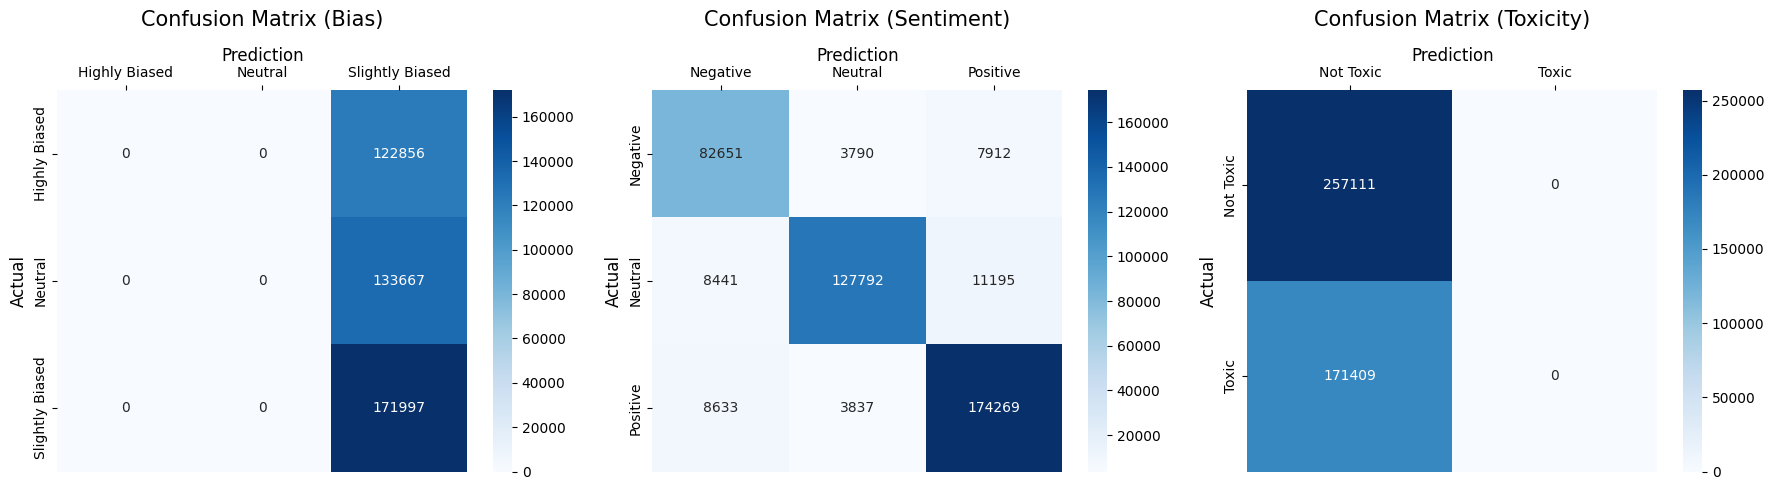

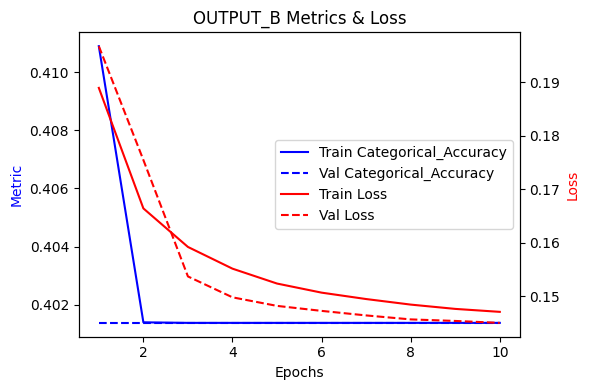

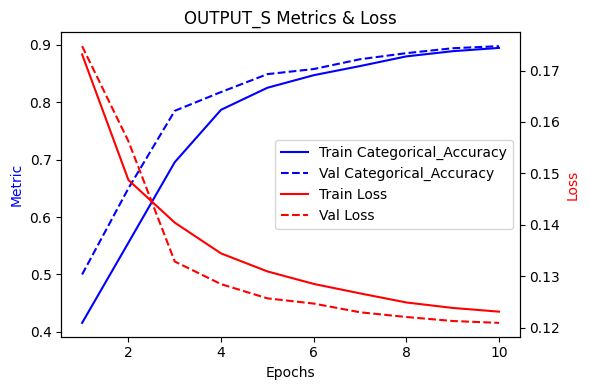

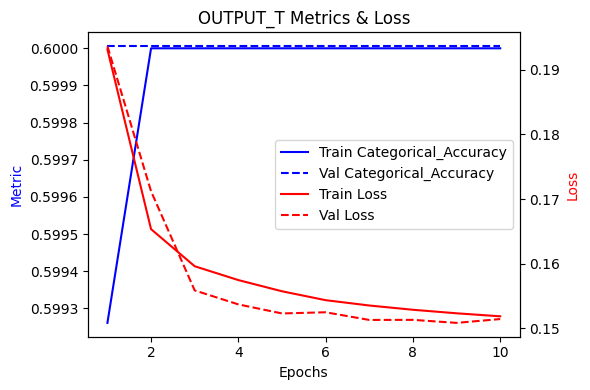


--------------------------------------------------------------------------

3348/3348 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Training with α=0.2, β=0.3, γ=0.5
====================== Bias Task ======================
Accuracy: 0.8573415476523849
                 precision    recall  f1-score   support

  Highly Biased       0.90      0.86      0.88    122856
        Neutral       0.86      0.90      0.88    133667
Slightly Biased       0.83      0.82      0.83    171997

       accuracy                           0.86    428520
      macro avg       0.86      0.86      0.86    428520
   weighted avg       0.86      0.86      0.86    428520


==================== Sentiment Task ====================
Accuracy: 0.9065037804536544
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87     94353
     Neutral       0.92      0.89      0.91    147428
    Positive       0.92      0.93      0.93    186739

    accuracy                           0.91    42852

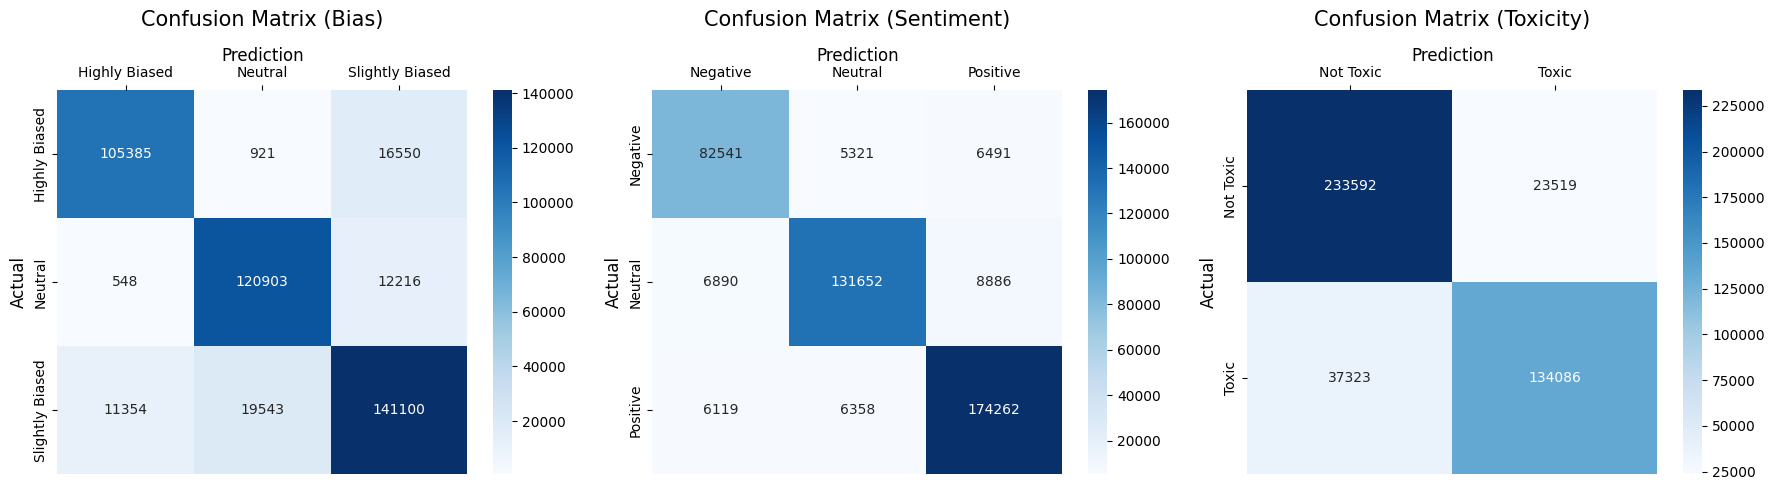

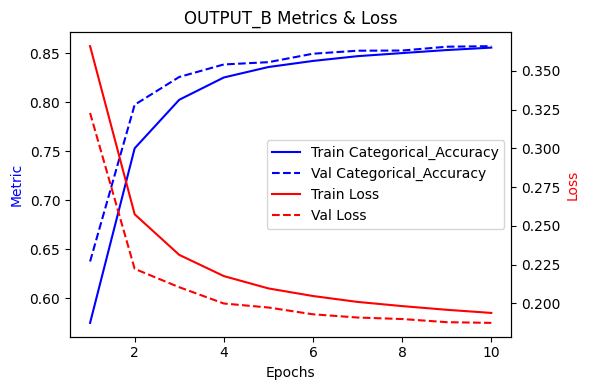

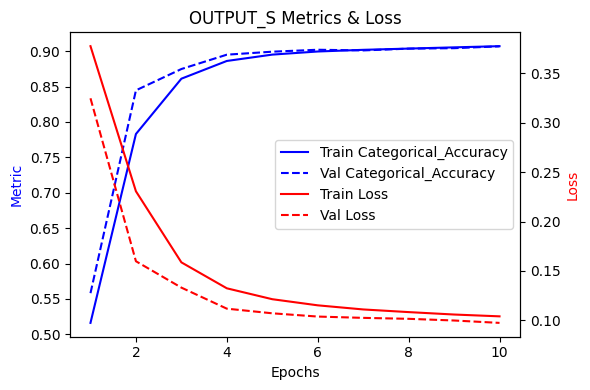

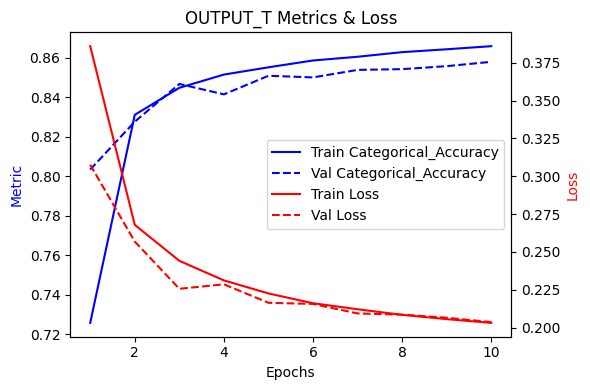


--------------------------------------------------------------------------



In [17]:
def to_int_labels(y):
    if len(y.shape) > 1 and y.shape[1] > 1:
        return np.argmax(y, axis=1)
    return y

y_test_bias_int = to_int_labels(y_test_bias)
y_test_sentiment_int = to_int_labels(y_test_sentiment)
y_test_toxic_int = to_int_labels(y_test_toxic)

for i in range(len(models_created)):
    bias_labels = ['Highly Biased', 'Neutral', 'Slightly Biased']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    toxicity_labels = ['Not Toxic', 'Toxic']
    
    y_pred_probs = models_created[i].predict(X_test, batch_size=128)
    
    # Convert predicted probabilities to class indices
    y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
    y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
    y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)
    
    val = combinations[i]
    print(f"\nTraining with α={val[0]}, β={val[1]}, γ={val[2]}")

    print("====================== Bias Task ======================")
    print("Accuracy:", accuracy_score(y_test_bias_int, y_pred_bias))
    print(classification_report(y_test_bias_int, y_pred_bias, target_names=bias_labels))
    
    print("\n==================== Sentiment Task ====================")
    print("Accuracy:", accuracy_score(y_test_sentiment_int, y_pred_sentiment))
    print(classification_report(y_test_sentiment_int, y_pred_sentiment, target_names=sentiment_labels))
    
    print("\n====================== Toxic Task ======================")
    print("Accuracy:", accuracy_score(y_test_toxic_int, y_pred_toxic))
    print(classification_report(y_test_toxic_int, y_pred_toxic, target_names=toxicity_labels))
    print("\n")

    def plot_cm(y_true, y_pred, labels, title, ax):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
        ax.set_title(title, fontsize=15, pad=15)
        ax.set_xlabel('Prediction', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    plot_cm(y_test_bias_int, y_pred_bias, ['Highly Biased', 'Neutral','Slightly Biased'], 'Confusion Matrix (Bias)', axes[0])
    plot_cm(y_test_sentiment_int, y_pred_sentiment, ['Negative', 'Neutral', 'Positive'], 'Confusion Matrix (Sentiment)', axes[1])
    plot_cm(y_test_toxic_int, y_pred_toxic, ['Not Toxic', 'Toxic'], 'Confusion Matrix (Toxicity)', axes[2])
    
    plt.tight_layout()
    plt.show()
    print("\n")

    def plot_history_combined(history, outputs, metrics=None):
        if metrics is None:
            metrics = []
            for key in history.history.keys():
                for output in outputs:
                    if key.startswith(output) and not key.endswith("loss"):
                        metric_name = key[len(output)+1:]  # remove output_
                        if metric_name not in metrics:
                            metrics.append(metric_name)
        
        epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)
    
        for output in outputs:
            fig, ax1 = plt.subplots(figsize=(6, 4))
    
            ax2 = ax1.twinx()
            for metric in metrics:
                train_metric = history.history.get(f"{output}_{metric}")
                val_metric = history.history.get(f"val_{output}_{metric}")
                if train_metric and val_metric:
                    ax1.plot(epochs, train_metric, "b-", label=f"Train {metric.title()}")
                    ax1.plot(epochs, val_metric, "b--", label=f"Val {metric.title()}")
    
            train_loss = history.history.get(f"{output}_loss")
            val_loss = history.history.get(f"val_{output}_loss")
            if train_loss and val_loss:
                ax2.plot(epochs, train_loss, "r-", label="Train Loss")
                ax2.plot(epochs, val_loss, "r--", label="Val Loss")
    
            ax1.set_xlabel("Epochs")
            ax1.set_ylabel("Metric", color="b")
            ax2.set_ylabel("Loss", color="r")
            ax1.set_title(f"{output.upper()} Metrics & Loss")
    
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    
            plt.tight_layout()
            plt.show()
    
    outputs = ["output_b", "output_s", "output_t"]
    plot_history_combined(history_created[i], outputs)
    
    print("\n--------------------------------------------------------------------------\n")

